# 뉴스 편향성 분석 모델

이 노트북은 뉴스 기사의 민주당과 국힘에 대한 편향성을 분석하는 딥러닝 모델을 구현합니다.

In [43]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer,
    AutoModel,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback,
    DataCollatorWithPadding
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [44]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. 데이터 로드 및 전처리

In [45]:
# 베이스라인 결과 로드
baseline_results = pd.read_csv('/content/drive/MyDrive/텍스트데이터분석을 위한 딥러닝/팀프로젝트/baseline_results/baseline_results.csv').iloc[0]

In [46]:
# 데이터 로드
df = pd.read_csv('/content/drive/MyDrive/텍스트데이터분석을 위한 딥러닝/팀프로젝트/data/라벨링_자동분류결과.csv')

# 스탠스 레이블 매핑
stance_mapping = {'우호': 0, '중립': 1, '비판': 2}

# 스탠스 레이블 변환
df['stance_label'] = df['auto_label'].map(stance_mapping)

# NaN 값 처리
df = df.dropna(subset=['text', 'stance_label'])

print(f"전체 데이터 수: {len(df)}")
print("\n정당별 기사 수:")
print(df['party'].value_counts())
print("\n스탠스 분포:")
print(df['stance_label'].value_counts())

전체 데이터 수: 400

정당별 기사 수:
party
민주당     200
국민의힘    200
Name: count, dtype: int64

스탠스 분포:
stance_label
1    216
2    148
0     36
Name: count, dtype: int64


## 2. 데이터셋 클래스 정의

In [47]:
class NewsDataset(Dataset):
    def __init__(self, texts, stance_labels, tokenizer, max_length=512):
        self.texts = texts
        self.stance_labels = stance_labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # 텐서 차원 조정
        input_ids = encoding['input_ids'].squeeze(0)  # [max_length]
        attention_mask = encoding['attention_mask'].squeeze(0)  # [max_length]

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'stance_label': torch.tensor(self.stance_labels[idx], dtype=torch.long)
        }

## 3. 모델 정의

In [48]:
class MultiTaskNewsModel(torch.nn.Module):
    def __init__(self, model_name, num_stance_labels=3, num_sentiment_labels=3, mask_token_id=50264, class_weights=None):
        super().__init__()
        # 기본 모델 로드
        self.bert = AutoModel.from_pretrained(model_name)
        self.mask_token_id = mask_token_id
        self.register_buffer("class_weights", torch.tensor(class_weights, dtype=torch.float))

        # 드롭아웃 레이어
        self.dropout = torch.nn.Dropout(0.2)

        # 공통 특성 추출 레이어
        hidden_size = self.bert.config.hidden_size
        self.shared_layer = torch.nn.Linear(hidden_size, 256)
        self.activation = torch.nn.ReLU()

        # 스탠스 분류기
        self.stance_classifier = torch.nn.Sequential(
            torch.nn.Linear(256, 128),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.1),
            torch.nn.Linear(128, num_stance_labels)
        )

        # 감성 분류기
        self.sentiment_classifier = torch.nn.Sequential(
            torch.nn.Linear(256, 128),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.1),
            torch.nn.Linear(128, num_sentiment_labels)
        )

        # 감성 손실 계산용 vocab projection 레이어
        self.sentiment_vocab_projection = torch.nn.Linear(hidden_size, self.bert.config.vocab_size)

        # 모델 가중치 초기화
        self._init_weights()

    def _init_weights(self):
        """모델 가중치 초기화"""
        for module in [self.shared_layer, self.stance_classifier, self.sentiment_classifier]:
            for m in module.modules():
                if isinstance(m, torch.nn.Linear):
                    torch.nn.init.xavier_uniform_(m.weight)
                    if m.bias is not None:
                        torch.nn.init.zeros_(m.bias)

    def forward(self, input_ids, attention_mask, stance_label=None):
        # BERT 출력
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :]  # [CLS] 토큰

        # 공통 특성 추출
        shared_features = self.dropout(pooled_output)
        shared_features = self.shared_layer(shared_features)
        shared_features = self.activation(shared_features)

        # 스탠스 예측
        stance_logits = self.stance_classifier(shared_features)

        # 감성 예측
        sentiment_logits = self.sentiment_classifier(shared_features)

        if stance_label is not None:
            # 스탠스 손실 계산
            loss_fct = torch.nn.CrossEntropyLoss(weight=self.class_weights)
            stance_loss = loss_fct(stance_logits, stance_label)

            # 감성 분석 손실 계산
            sentiment_loss = self._compute_sentiment_loss(sentiment_logits, input_ids, attention_mask)

            # 총 손실 계산
            total_loss = stance_loss + 0.5 * sentiment_loss

            return {
                'loss': total_loss,
                'stance_logits': stance_logits,
                'sentiment_logits': sentiment_logits
            }

        return {
            'stance_logits': stance_logits,
            'sentiment_logits': sentiment_logits
        }

    def _compute_sentiment_loss(self, sentiment_logits, input_ids, attention_mask):
        """단순화된 감성 분석 손실 계산"""
        try:
            # 마스킹된 입력 생성
            masked_input_ids = input_ids.clone()
            mask_prob = 0.15

            # 마스킹 마스크 생성 (패딩 토큰 제외)
            mask_mask = torch.rand_like(input_ids.float()) < mask_prob
            mask_mask = mask_mask & (attention_mask == 1)

            if not mask_mask.any():
                return torch.tensor(0.0, device=input_ids.device)

            # 마스킹 적용
            mask_token_id = self.mask_token_id
            masked_input_ids[mask_mask] = mask_token_id

            # 마스킹된 입력에 대한 예측
            # 입력 텐서의 차원 확인 및 조정
            if len(masked_input_ids.shape) == 1:
                masked_input_ids = masked_input_ids.unsqueeze(0)
            if len(attention_mask.shape) == 1:
                attention_mask = attention_mask.unsqueeze(0)

            # BERT 모델에 입력
            masked_outputs = self.bert(
                input_ids=masked_input_ids,
                attention_mask=attention_mask,
                return_dict=True
            )

            # 마스킹된 위치의 로짓 추출
            last_hidden_state = masked_outputs.last_hidden_state  # [batch_size, seq_len, hidden_size]
            masked_positions = mask_mask.nonzero(as_tuple=True)  # (batch_indices, seq_indices)

            # 마스킹된 위치의 로짓만 추출
            masked_logits = last_hidden_state[masked_positions]  # [num_masked, hidden_size]

            # 원본 입력과의 차이를 손실로 사용
            target_ids = input_ids[mask_mask]  # [num_masked]

            # 로짓을 어휘 크기에 맞게 변환
            vocab_size = self.bert.config.vocab_size

            # 로짓 투사 후 CrossEntropyLoss 계산
            masked_logits = self.sentiment_vocab_projection(masked_logits)

            # 라벨 범위 검증
            assert torch.max(target_ids) < vocab_size, f"target_id max {torch.max(target_ids)} >= vocab size {vocab_size}"
            assert torch.min(target_ids) >= 0, f"target_id min {torch.min(target_ids)} < 0"

            # 손실 계산
            loss_fct = torch.nn.CrossEntropyLoss()
            sentiment_loss = loss_fct(masked_logits, target_ids)

            return sentiment_loss

        except Exception as e:
            print(f"감성 분석 손실 계산 중 오류 발생: {str(e)}")
            return torch.tensor(0.0, device=input_ids.device)

## 4. 학습 준비

In [49]:
# 데이터 분할
train_texts, val_texts, train_party_labels, val_party_labels, train_stance_labels, val_stance_labels = train_test_split(
    df['text'].values,
    df['party'].values,
    df['stance_label'].values,
    test_size=0.1,
    random_state=42
)

In [50]:
# 토크나이저 초기화
tokenizer = AutoTokenizer.from_pretrained('klue/roberta-base')

# 데이터셋 생성
train_dataset = NewsDataset(train_texts, train_stance_labels, tokenizer)
val_dataset = NewsDataset(val_texts, val_stance_labels, tokenizer)

In [51]:
label_list = [example['stance_label'] for example in train_dataset]
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1, 2]),
    y=np.array(label_list)
)
print("클래스 가중치:", class_weights)

클래스 가중치: [3.87096774 0.6122449  0.90225564]


In [52]:
# 모델 초기화
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 모델 초기화 및 GPU 이동을 분리
model = MultiTaskNewsModel('klue/roberta-base', mask_token_id=tokenizer.mask_token_id, class_weights=class_weights)
model = model.to(device)

# 커스텀 데이터 콜레이터
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [56]:
def compute_metrics(eval_pred):
    stance_preds, sentiment_preds = eval_pred.predictions
    stance_labels = eval_pred.label_ids

    stance_preds = np.argmax(stance_preds, axis=1)
    sentiment_logits = torch.tensor(sentiment_preds, dtype=torch.float32)

    stance_report = classification_report(
        stance_labels,
        stance_preds,
        target_names=['우호', '중립', '비판'],
        output_dict=True,
        zero_division=0
    )

    # 감성 softmax 평균 출력용
    sentiment_softmax = torch.nn.functional.softmax(sentiment_logits, dim=-1).numpy()
    mean_sentiment = sentiment_softmax.mean(axis=0)  # 긍/중/부 평균 확률

    return {
        'stance_f1': stance_report['weighted avg']['f1-score'],
        'stance_accuracy': stance_report['accuracy'],
    }

In [60]:
# 학습 인자 설정
training_args = TrainingArguments(
    output_dir='./multitask_results',
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=1e-5,
    warmup_ratio=0.1,
    weight_decay=0.05,
    logging_dir='./multitask_logs',
    logging_steps=100,
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='stance_f1',
    gradient_accumulation_steps=2,  # 그래디언트 누적
    fp16=True,  # 혼합 정밀도 학습
    label_smoothing_factor=0.1,  # 레이블 스무딩
    optim='adamw_torch'  # AdamW 옵티마이저 사용
)

# 트레이너 초기화
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2, early_stopping_threshold=0.001)]
)

## 5. 학습 및 평가

In [61]:
# 학습 실행
trainer.train()

# 최종 평가
final_metrics = trainer.evaluate()
print("\n최종 평가 결과:")
print(f"스탠스 F1 점수: {final_metrics['eval_stance_f1']:.4f}")
print(f"스탠스 정확도: {final_metrics['eval_stance_accuracy']:.4f}")

Epoch,Training Loss,Validation Loss,Stance F1,Stance Accuracy
1,No log,6.305852,0.523519,0.550000
2,No log,6.446114,0.563718,0.575000
3,No log,6.778306,0.396796,0.450000
4,No log,6.761790,0.427846,0.450000


{'우호': {'precision': 0.5, 'recall': 0.2, 'f1-score': 0.2857142857142857, 'support': 5.0}, '중립': {'precision': 0.6666666666666666, 'recall': 0.4, 'f1-score': 0.5, 'support': 20.0}, '비판': {'precision': 0.5, 'recall': 0.8666666666666667, 'f1-score': 0.6341463414634146, 'support': 15.0}, 'accuracy': 0.55, 'macro avg': {'precision': 0.5555555555555555, 'recall': 0.48888888888888893, 'f1-score': 0.4732868757259001, 'support': 40.0}, 'weighted avg': {'precision': 0.5833333333333333, 'recall': 0.55, 'f1-score': 0.5235191637630662, 'support': 40.0}}
평균 감정 분포 (softmax): [0.37421745 0.45653385 0.16924872]
{'우호': {'precision': 0.3333333333333333, 'recall': 0.2, 'f1-score': 0.25, 'support': 5.0}, '중립': {'precision': 0.5833333333333334, 'recall': 0.7, 'f1-score': 0.6363636363636364, 'support': 20.0}, '비판': {'precision': 0.6153846153846154, 'recall': 0.5333333333333333, 'f1-score': 0.5714285714285714, 'support': 15.0}, 'accuracy': 0.575, 'macro avg': {'precision': 0.5106837606837608, 'recall': 0.4777

{'우호': {'precision': 0.3333333333333333, 'recall': 0.2, 'f1-score': 0.25, 'support': 5.0}, '중립': {'precision': 0.5833333333333334, 'recall': 0.7, 'f1-score': 0.6363636363636364, 'support': 20.0}, '비판': {'precision': 0.6153846153846154, 'recall': 0.5333333333333333, 'f1-score': 0.5714285714285714, 'support': 15.0}, 'accuracy': 0.575, 'macro avg': {'precision': 0.5106837606837608, 'recall': 0.4777777777777777, 'f1-score': 0.48593073593073594, 'support': 40.0}, 'weighted avg': {'precision': 0.5641025641025641, 'recall': 0.575, 'f1-score': 0.5637175324675324, 'support': 40.0}}
평균 감정 분포 (softmax): [0.3866403  0.44759494 0.16576481]

최종 평가 결과:
스탠스 F1 점수: 0.5637
스탠스 정확도: 0.5750


In [62]:
# 베이스라인과 성능 비교
comparison_results = {
    'Model': ['Baseline', 'Multitask BERT'],
    'Stance F1': [baseline_results['stance_f1'], final_metrics['eval_stance_f1']],
    'Stance Accuracy': [baseline_results['stance_accuracy'], final_metrics['eval_stance_accuracy']],
}

comparison_df = pd.DataFrame(comparison_results)
comparison_df.to_csv('./multitask_results/model_comparison.csv', index=False)
comparison_df.head()

,Model,Stance F1,Stance Accuracy
0,Baseline,0.694253,0.700
1,Multitask BERT,0.563718,0.575


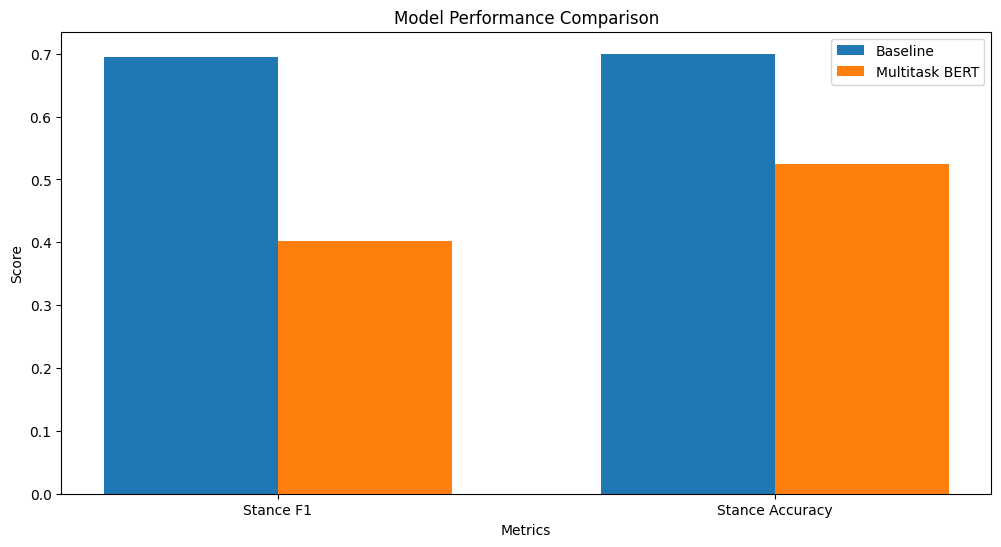

In [25]:
# 성능 향상 시각화
plt.figure(figsize=(12, 6))
metrics = ['Stance F1', 'Stance Accuracy']
x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, comparison_df.iloc[0, 1:], width, label='Baseline')
plt.bar(x + width/2, comparison_df.iloc[1, 1:], width, label='Multitask BERT')

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x, metrics)
plt.legend()

plt.savefig('./multitask_results/performance_comparison.png')
plt.show()

## 6. 모델 저장 및 로드

In [ ]:
# 모델 저장
trainer.save_model('./best_model')
tokenizer.save_pretrained('./best_model')

# 모델 로드
def load_model(model_path):
    model = MultiTaskNewsModel('klue/roberta-base')
    model.load_state_dict(torch.load(f'{model_path}/pytorch_model.bin'))
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    return model, tokenizer

## 7. 새로운 기사에 대한 예측

In [ ]:
def predict_news(text, model, tokenizer, device):
    model.eval()
    encoding = tokenizer(
        text,
        add_special_tokens=True,
        max_length=512,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        stance_pred = torch.argmax(outputs['stance_logits'], dim=1).item()
        sentiment_pred = torch.argmax(outputs['sentiment_logits'], dim=1).item()

    return stance_pred, sentiment_pred

In [ ]:
def predict_csv_file(csv_path, model, tokenizer, device):
    # CSV 파일 로드
    df = pd.read_csv(csv_path)

    # 예측 결과를 저장할 리스트
    stance_predictions = []
    sentiment_predictions = []

    # 각 텍스트에 대해 예측 수행
    for text in tqdm(df['text'], desc="Predicting"):
        stance_pred, sentiment_pred = predict_news(text, model, tokenizer, device)
        stance_predictions.append(stance_pred)
        sentiment_predictions.append(sentiment_pred)

    # 예측 결과를 DataFrame에 추가
    df['stance_label'] = stance_predictions
    df['sentiment_label'] = sentiment_predictions

    # 예측 결과를 숫자에서 텍스트로 변환
    stance_mapping = {v: k for k, v in stance_mapping.items()}
    sentiment_mapping = {v: k for k, v in sentiment_mapping.items()}

    df['stance'] = df['stance_label'].map(stance_mapping)
    df['sentiment'] = df['sentiment_label'].map(sentiment_mapping)

    # 결과 저장
    output_path = csv_path.replace('.csv', '_predicted.csv')
    df.to_csv(output_path, index=False)

    # 예측 결과 통계 출력
    print(f"\n{csv_path} 예측 결과:")
    print("\n스탠스 예측 분포:")
    print(df['stance'].value_counts())
    print("\n감성 예측 분포:")
    print(df['sentiment'].value_counts())

    return df

In [ ]:
# 모델 로드
model, tokenizer = load_model('./best_model')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# CSV 파일 예측
csv_path = "/content/drive/MyDrive/텍스트데이터분석을 위한 딥러닝/팀프로젝트/data/전체1.csv"  # 여기에 실제 CSV 파일 경로를 입력하시면 됩니다
predicted_df = predict_csv_file(csv_path, model, tokenizer, device)
predicted_df.head()

In [ ]:
# 저장
predicted_df.to_csv(csv_path, index=False)